In [1]:
import torch
from model import ClipGPT

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'Using device: {device}')

net = ClipGPT(device=device, generator='gpt2').to(device)
net.load_state_dict(torch.load('data/models/full.pth', map_location=device))

Using device: mps


<All keys matched successfully>

In [2]:
from dataset import get_test_datasets

test_datasets = get_test_datasets(net.preprocess_clip)
print(f'Test datasets: {test_datasets.keys()}')

Test datasets: dict_keys(['rsicd', 'ucm', 'nwpu', 'sydney'])


['This is a baseball diamond .', 'It is an old baseball diamond with sand and weeds .', 'It is a small baseball diamond .', 'An old baseball diamond compose of sand and weeds .', 'An old baseball diamond compose of sand and weeds .']
torch.Size([3, 224, 224])
['There are two baseball diamonds in the grass surrounded by the houses and roads .']


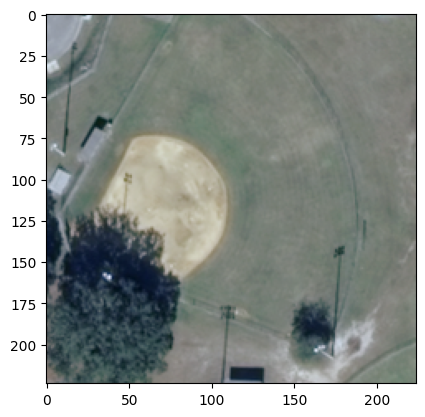

In [3]:
# print one image and text pair
sample = test_datasets['ucm'][21]
print(sample['captions'])
print(sample['x'].shape)

# print image
import matplotlib.pyplot as plt
img = sample['x'].permute(1, 2, 0).cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())
plt.imshow(img)

# get descritpion
clip_emb = net.clip.encode_image(sample['x'].unsqueeze(0).to(device))
desc = net.get_caption(clip_embedding=clip_emb)
print(desc)



In [18]:
from pycocoevalcap.bleu.bleu import Bleu


refs = { 0 : sample['captions']}
res = { 0 : desc }
bleu1_scorer = Bleu(n=4)
bleu1_score = bleu1_scorer.compute_score(refs, res, verbose=False)
print(f'BLEU-1: {bleu1_score}')

# cider
from pycocoevalcap.cider.cider import Cider
cider_scorer = Cider()
cider_score, _ = cider_scorer.compute_score(refs, res)
print(f'CIDEr: {cider_score}')

# rouge
from pycocoevalcap.rouge.rouge import Rouge
rouge_scorer = Rouge()
rouge_score = rouge_scorer.compute_score(refs, res)
print(f'ROUGE: {rouge_score}')


BLEU-1: ([0.19999999998666673, 3.7796447298312975e-09, 1.0319362512278992e-11, 5.501034141770605e-13], [[0.19999999998666673], [3.7796447298312975e-09], [1.0319362512278992e-11], [5.501034141770605e-13]])
CIDEr: 0.0
ROUGE: (0.26180257510729615, array([0.26180258]))


In [5]:
import torch

# Enable anomaly detection
torch.autograd.set_detect_anomaly(True)

# Example initialization of tensors with requires_grad=True
Ci = torch.rand(3, requires_grad=True)
Cj = torch.rand(3, requires_grad=True)
Ck1 = torch.rand(3, requires_grad=True)
Ck2 = torch.rand(3, requires_grad=True)

# Ensure no in-place modifications are performed by using clone()
Ci_expanded = Ci[:, None, None, None].clone()  # Shape (3, 1, 1, 1)
Cj_expanded = Cj[None, :, None, None].clone()  # Shape (1, 3, 1, 1)
Ck1_expanded = Ck1[None, None, :, None].clone()  # Shape (1, 1, 3, 1)
Ck2_expanded = Ck2[None, None, None, :].clone()  # Shape (1, 1, 1, 3)

# Verify the shapes to ensure correct broadcasting
print("Ci_expanded shape:", Ci_expanded.shape)
print("Cj_expanded shape:", Cj_expanded.shape)
print("Ck1_expanded shape:", Ck1_expanded.shape)
print("Ck2_expanded shape:", Ck2_expanded.shape)

# Perform the multiplication step by step and check for in-place modifications
eta_step1 = Ci_expanded * Cj_expanded
eta_step2 = eta_step1 * Ck1_expanded
eta = eta_step2 * Ck2_expanded

# Verify the resulting shape
print("eta shape:", eta.shape)

# To verify gradients work correctly, perform a simple backward operation
loss = eta.sum()
loss.backward()

# Check gradients
print("Ci.grad:", Ci.grad)
print("Cj.grad:", Cj.grad)
print("Ck1.grad:", Ck1.grad)
print("Ck2.grad:", Ck2.grad)

Ci_expanded shape: torch.Size([3, 1, 1, 1])
Cj_expanded shape: torch.Size([1, 3, 1, 1])
Ck1_expanded shape: torch.Size([1, 1, 3, 1])
Ck2_expanded shape: torch.Size([1, 1, 1, 3])
eta shape: torch.Size([3, 3, 3, 3])
Ci.grad: tensor([4.5349, 4.5349, 4.5349])
Cj.grad: tensor([6.6897, 6.6897, 6.6897])
Ck1.grad: tensor([4.0519, 4.0519, 4.0519])
Ck2.grad: tensor([4.4012, 4.4012, 4.4012])


In [20]:
torch.arange(8, 10)

tensor([8, 9])